## Update 5 - Part 1


1. 20 realizations of facies (applying sequential indicator simulation)

In [1]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.

In [2]:
class Univariate():
    def __init__(self,welldata):
        self.filename = welldata # set filename
        self.welldata = pd.read_csv(welldata) # read well data into dataframe
        #self.sandstone = self.welldata.loc[(data.welldata['Facies'] == 1)] # Group by facies (Sandstone)
        #self.shale = self.welldata.loc[(data.welldata['Facies'] == 0)] # Group by facies (Shale)

        
    def comp_outliers(self,dataframe,metric):
        # computes the upper and lower fence based on Tukey 1.5 x IQR method and returns an array of format 
        # [lower_fence,upper_fence]
        P25 = np.percentile(dataframe[metric].values,25)
        P75 = np.percentile(dataframe[metric].values,75)
        lower_fence = P25 - 1.5*(P75-P25)
        upper_fence = P75 + 1.5*(P75-P25)
        if lower_fence < 0.0:
            lower_fence = 0.0
        return [lower_fence,upper_fence]
    
    def remove_outliers(self,dataframe,metric):
        # removes outliers from dataframe and returns new dataframe without outliers
        bounds = self.comp_outliers(dataframe,metric)
        cleaned_data = dataframe.loc[(dataframe[metric] >= bounds[0]) & (dataframe[metric] <= bounds[1])]
        return cleaned_data 

In [3]:
# load original csv file
data = Univariate('Data/1_sample_data.csv')

In [4]:
# doing facies separation and outlier removal
# pulling out the raw facies data
Sandstone_raw = data.welldata.loc[(data.welldata['Facies'] == 1)]
Shale_raw = data.welldata.loc[(data.welldata['Facies'] == 0)]
# outlier removal for sandstone (porosity, permeability, acoustic impedance)
Sandstone_cleaned_por = data.remove_outliers(Sandstone_raw,'Porosity')
Sandstone_cleaned_por_perm = data.remove_outliers(Sandstone_cleaned_por,'Perm')
Sandstone_final = data.remove_outliers(Sandstone_cleaned_por_perm,'AI')
# outlier removal for shale (porosity, permeability, acoustic impedance)
Shale_cleaned_por = data.remove_outliers(Shale_raw,'Porosity')
Shale_cleaned_por_perm = data.remove_outliers(Shale_cleaned_por,'Perm')
Shale_final = data.remove_outliers(Shale_cleaned_por_perm,'AI')

In [5]:
# combining facies for total 'cleaned' dataset
df = pd.concat([Sandstone_final,Shale_final])
del df['Unnamed: 0']

## 1. Facies SIS
The facies locations are simulated using sequential indicator simulation.

In [6]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 100; skmean = 0
tmin = -999; tmax = 999
dummy_trend = np.zeros((10,10))            # the current version requires trend input - if wrong size it is ignored 

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories (use consistent order)
gcdf = [0.24,0.76]                         # the global proportions of the categories - from update 4
varios = []                                # the variogram list

In [7]:
# indicator variograms for facies from update 4
# fit porosity model variogram to experimental
nug = 0.1                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 2; it2 = 3            # defining types of model variograms 1=spherical, 2=exponential, 3=Gaussian
cc1 = 0.7; cc2 = 0.2       # defining contributions of each structure
azi1 = 112.5; azi2 = 112.5     # defining major azimuthal direction
hmaj1 = 250; hmaj2 = 500     # defining range in major direction
hmin1 = 200; hmin2 = 220     # defining range in minor direction

# appending variograms to list to be consistent with demo workflow
# for 2 facies the indicator variograms for sand and shale are the same
varios.append(GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2))
varios.append(GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2))

In [8]:
# do the SIS
numplots = 2
# loop
sim_ik = np.zeros([numplots,100,100]) # preallocate array to hold simulation results
for i in range(0,numplots):
    sim_ik[i,:,:] = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
                    tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
                    nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = i,
                    ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios)

Data for IK3D: Variable column Facies
  Number   = 217
Setting up rotation matrices for variogram and search
Working on a single realization, seed 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 217
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000


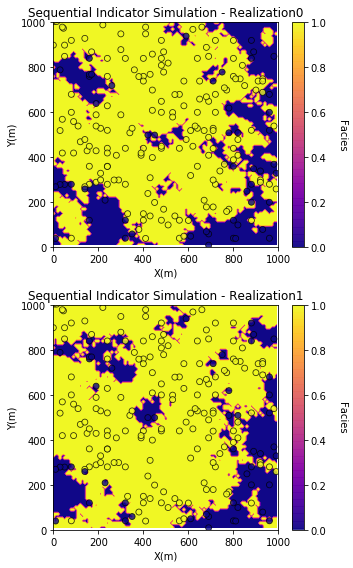

In [9]:
# plot realizations of the SIS
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.plasma # plotting parameters
# loop
plt.figure(figsize=(5,4*numplots))
for i in range(0,numplots):
    plt.subplot(numplots,1,i+1)
    GSLIB.locpix_st(sim_ik[i,:,:],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization' + str(i),'X(m)','Y(m)','Facies',cmap)

plt.tight_layout()
plt.show()